## Install and import libraries

In [4]:
pip install h5py typing-extensions wheel

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install diffrax equinox jax optax scipy cvxpy

Note: you may need to restart the kernel to use updated packages.


In [6]:
import time

import diffrax
import equinox as eqx  # https://github.com/patrick-kidger/equinox
import jax
import jax.nn as jnn
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax
from sklearn.preprocessing import MinMaxScaler
from scipy import interpolate

# import equinox.experimental as eqxe
import jax.tree_util as jtu
import functools as ft

import cvxpy as cp


## Load and pre-process data

In [7]:
# Reading data from text file

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler



Using LASA DataSet from /home/zhitao/miniconda3/envs/obs-env/lib/python3.10/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


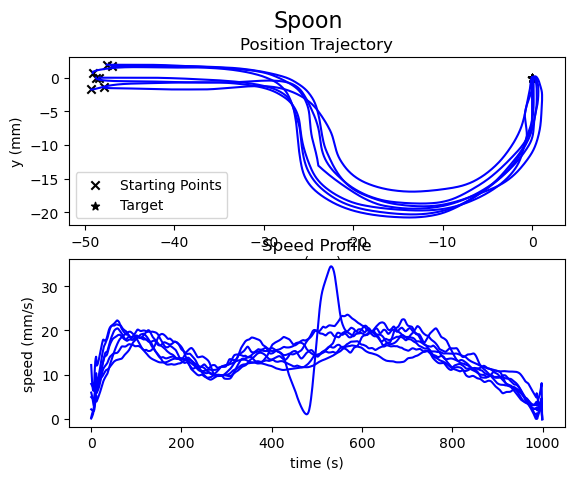

In [8]:
import pyLasaDataset as lasa

# DataSet object has all the LASA handwriting data files
# as attributes, eg:
angle_data = lasa.DataSet.Angle
sine_data = lasa.DataSet.Sine
Leaf_2_data = lasa.DataSet.Leaf_2
CShape_data = lasa.DataSet.CShape
DoubleBendedLine = lasa.DataSet.DoubleBendedLine

data = lasa.DataSet.Spoon


# Each Data object has attributes dt and demos (For documentation,
# refer original dataset repo:
# https://bitbucket.org/khansari/lasahandwritingdataset/src/master/Readme.txt)
dt = data.dt
demos = data.demos # list of 7 Demo objects, each corresponding to a
                         # repetition of the pattern


# Each Demo object in demos list will have attributes pos, t, vel, acc
# corresponding to the original .mat format described in
# https://bitbucket.org/khansari/lasahandwritingdataset/src/master/Readme.txt
demo_0 = demos[1]
pos = demo_0.pos # np.ndarray, shape: (2,2000)
vel = demo_0.vel # np.ndarray, shape: (2,2000)
acc = demo_0.acc # np.ndarray, shape: (2,2000)
t = demo_0.t # np.ndarray, shape: (1,2000)


# To visualise the data (2D position and velocity) use the plot_model utility
lasa.utilities.plot_model(data) # give any of the available
                                                   # pattern data as argument

In [9]:

ndemos = len(demos)
T = demos[0].t.shape[-1]
pos_all = []
vel_all = []
for i in range(ndemos):
  pos_all.append((demos[i].pos).T)
  vel_all.append((demos[i].vel).T)
posn = jnp.array(pos_all)
veln = jnp.array(vel_all)
ts_new =  jnp.array(t.T).reshape(T)
ys_all_n = jnp.concatenate((posn,veln),axis=2)

In [10]:
nsamples = 1000
ts = t[0]/t[0, -1]
ts_new = jnp.linspace(0, 1, nsamples)

dim = posn.shape[2]

traj_process = jnp.zeros((ndemos, nsamples, dim))
vel_process = jnp.zeros((ndemos, nsamples, dim))

traj_all_t_norm = []
# time_all_process = jnp.zeros((traj_c, nsamples))

seed = 1385

key = jax.random.PRNGKey(seed)
scale_state = 1

key_trajs = jax.random.split(key, num=ndemos)

for i in range(ndemos):
  key_dim = jax.random.split(key_trajs[i], num=dim)
  for j in range(dim):
    f = interpolate.interp1d(ts, posn[i, :, j])
    f_vel = interpolate.interp1d(ts, veln[i, :, j])
    # f = interpolate.interp1d(time_all[i][:, 0], traj_all[i][:, j])
    # ts_new = np.linspace(time_all[i][0, 0], time_all[i][-1, 0], nsamples)
    # time_all_process = time_all_process.at[i].set(ts_new)
    traj_new = f(ts_new)
    vel_new = f_vel(ts_new)
    traj_process = traj_process.at[i, :, j].set(scale_state*traj_new)
    vel_process = vel_process.at[i, :, j].set(scale_state*vel_new)

## Train_Test_split

nTD = 4
traj_train = traj_process[1:nTD]
vel_train = vel_process[1:nTD]

traj_test = traj_process[nTD:]
vel_test = vel_process[nTD:]

## Multi_models

# train_indx = [0, 2, 4, 6]
# nTD = len(train_indx)
# traj_train = jnp.zeros((len(train_indx), nsamples, dim))
# vel_train = jnp.zeros((len(train_indx), nsamples, dim))
# c=0

# for i in train_indx:
#   traj_train = traj_train.at[c].set(traj_process[i])
#   vel_train = vel_train.at[c].set(vel_process[i])
#   c += 1

# test_indx = [1, 3, 5]
# traj_test = jnp.zeros((len(test_indx), nsamples, dim))
# vel_test = jnp.zeros((len(test_indx), nsamples, dim))
# c=0

# for i in test_indx:
#   traj_test = traj_test.at[c].set(traj_process[i])
#   vel_test = vel_test.at[c].set(vel_process[i])
#   c += 1

traj_all_train = jnp.concatenate((traj_train, vel_train), axis=2)
traj_all_test = jnp.concatenate((traj_test, vel_test), axis=2)

## Define models

In [11]:
class Func(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        initializer = jnn.initializers.orthogonal()
        self.mlp = eqx.nn.MLP(
            in_size=data_size,
            out_size=data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )
        model_key = key
        key_weights = jrandom.split(model_key, depth+1)

        for i in range(depth+1):
          where = lambda m: m.layers[i].weight
          shape = self.mlp.layers[i].weight.shape
          self.mlp = eqx.tree_at(where, self.mlp, replace=initializer(key_weights[i], shape, dtype = jnp.float32))

    def __call__(self, t, y, args):

        # return self.mlp(y)

        # model_with_sn = apply_sn(self.mlp)

        return self.mlp(y)

In [12]:
class Funcd(eqx.Module):
    mlp: eqx.nn.MLP

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.mlp = eqx.nn.MLP(
            in_size=2*data_size,
            out_size=2*data_size,
            width_size=width_size,
            depth=depth,
            activation=jnn.tanh,
            key=key,
        )

    def __call__(self, t, yd, args):

        # return self.mlp(y)
        return self.mlp(yd)

In [13]:
class NeuralODE(eqx.Module):
    func: Func

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Func(data_size, width_size, depth, key=key)

    def __call__(self, ts, yd0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=yd0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

In [14]:
class NeuralODEd(eqx.Module):
    func: Funcd

    def __init__(self, data_size, width_size, depth, *, key, **kwargs):
        super().__init__(**kwargs)
        self.func = Funcd(data_size, width_size, depth, key=key)

    def __call__(self, ts, yd0):
        solution = diffrax.diffeqsolve(
            diffrax.ODETerm(self.func),
            diffrax.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=yd0,
            stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
            saveat=diffrax.SaveAt(ts=ts),
        )
        return solution.ys

## Data loader

In [15]:
def dataloader(arrays, batch_size, *, key):
    dataset_size = arrays[0].shape[0]
    assert all(array.shape[0] == dataset_size for array in arrays)
    indices = jnp.arange(dataset_size)
    while True:
        perm = jrandom.permutation(key, indices)
        (key,) = jrandom.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield tuple(array[batch_perm] for array in arrays)
            start = end
            end = start + batch_size

## Train

In [ ]:
def main(
    dataset_size=nTD,
    batch_size=int(nTD/2),
    lr_strategy=(3e-3,),
    steps_strategy=(3000,),
    length_strategy=(1,),
    width_size=64,
    depth=3,
    seed=1000,
    plot=True,
    print_every=100,
    save_every=500,
):
    key = jrandom.PRNGKey(seed)
    data_key, model_key, loader_key = jrandom.split(key, 3)

    ys = traj_train
    ts = ts_new
    ys_dot = vel_train
    ys_all = traj_all_train

    # ys = posn[:nTD]
    # ts = tn
    # ys_dot = veln[:nTD]
    # ys_all = ys_all_n[:nTD]

    # file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/LASA_models/CoRL_2023/WShape_checkpoint.eqx"

    # ts, ys, ys_dot = get_data(dataset_size, key=data_key)

    # yst = jnp.copy(ys)

    # scaler = MinMaxScaler()
    # for i in range(dataset_size):
    #   scaler.fit(ys[i])
    #   ysti = scaler.transform(ys[i])
    #   yst = yst.at[i].set(ysti)
    #   # yst = jnp.expand_dims(yst, axis = 0)
    # scaler.fit(ts.reshape(-1,1))
    # tst = scaler.transform(ts.reshape(-1,1))
    # tst = tst.reshape(-1,)

    # ys = yst
    # ts = tst

    _, length_size, data_size = ys.shape

    model = NeuralODE(data_size, width_size, depth, key=model_key)

    # Training loop like normal.
    #
    # Only thing to notice is that up until step 500 we train on only the first 10% of
    # each time series. This is a standard trick to avoid getting caught in a local
    # minimum.

    @eqx.filter_value_and_grad
    def grad_loss(model, ti, yi):
        y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
        f = lambda t, z: model.func(t, z, _)
        # y_dot_pred = jax.vmap(jax.vmap(f, in_axes = (0, 0)), in_axes=(None, 0))(ti, yi)
        loss = jnp.mean((yi - y_pred) ** 2)
        # loss = jnp.mean((y_dot_pred - yi_dot)**2)
        return loss

    @eqx.filter_jit
    def make_step(ti, yi, model, opt_state):
        loss, grads = grad_loss(model, ti, yi)
        updates, opt_state = optim.update(grads, opt_state)
        model = eqx.apply_updates(model, updates)
        return loss, model, opt_state

    time_all = 0

    for lr, steps, length in zip(lr_strategy, steps_strategy, length_strategy):
        decay_scheduler = optax.cosine_decay_schedule(lr, decay_steps=steps, alpha=0.95)
        # decay_scheduler = optax.piecewise_constant_schedule(init_value=lr, boundaries_and_scales={int(steps*0.25):0.5, int(steps*0.5):0.5, int(steps*0.75):0.5})
        # decay_scheduler = optax.exponential_decay(init_value=lr, transition_steps=steps, decay_rate=0.98, transition_begin=int(steps*0.25), staircase=False)
        # decay_scheduler = optax.linear_schedule(init_value=lr, end_value=0.005*lr, transition_steps=steps, transition_begin=int(steps*0.25))
        optim = optax.adabelief(learning_rate=decay_scheduler)
        opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
        _ts = ts[: int(length_size * length)]
        _ys = ys[:, : int(length_size * length)]
        # _ys_dot = ys_dot[:, : int(length_size * length)]
        _ys_all = ys_all_n[:, :int(length_size * length)]
        ## Single trajectory
        # for step in range(steps):
        #   start = time.time()
        #   loss, model, opt_state = make_step(_ts, _ys, _ys_dot, model, opt_state)
        #   end = time.time()
        #   if (step % print_every) == 0 or step == steps - 1:
        #     print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")
        ## Batches
        for step, (yi,) in zip(
            range(steps), dataloader((_ys,), batch_size, key=loader_key)
        ):
            start = time.time()
            loss, model, opt_state = make_step(_ts, yi, model, opt_state)
            end = time.time()
            time_all += end - start
            if (step % print_every) == 0 or step == steps - 1:
                print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")
            # if (step % save_every) == 0 or step == steps - 1:
            #   eqx.tree_serialise_leaves(file_name, model)

    # if plot:
    #     plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
    #     plt.plot(ts, ys[0, :, 1], c="dodgerblue")
    #     model_y = model(ts, ys[0, 0])
    #     plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
    #     plt.plot(ts, model_y[:, 1], c="crimson")
    #     plt.legend()
    #     plt.tight_layout()
    #     plt.savefig("neural_ode.png")
    #     plt.show()

    return ts, ys, model, time_all

In [30]:
ts, ys, model, time_all = main()


NameError: name 'tn' is not defined

## Plot predicted trajectories

## Save the model

In [18]:
file_name = "/home/zhitao/Downloads/lasa_checkpoint.eqx"
eqx.tree_serialise_leaves(file_name, model)

## Load the model

In [20]:
# file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/Wiping_LR_hand_drawn_checkpoint.eqx"
# ys = traj_LR_all_process
# ts = ts_LR_new
# _, length_size, data_size = ys.shape
# width_size=64
# depth=3
# seed=1000
# key = jrandom.PRNGKey(seed)
# data_key, model_key, loader_key = jrandom.split(key, 3)
# model1 = NeuralODE(data_size, width_size, depth, key=model_key)
# model_load_LR = eqx.tree_deserialise_leaves(file_name, model1)

file_name = "/home/zhitao/Downloads/lasa_checkpoint.eqx"
ys = posn
ts = ts_new
_, length_size, data_size = ys.shape
width_size=64
depth=3
seed=1000
key = jrandom.PRNGKey(seed)
data_key, model_key, loader_key = jrandom.split(key, 3)
model1 = NeuralODE(data_size, width_size, depth, key=model_key)
model_load_TB = eqx.tree_deserialise_leaves(file_name, model1)

# file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/Wiping_hand_drawn/Wiping_TB_hand_drawn_spur_att_checkpoint.eqx"
# ys = traj_all_process
# ts = ts_new
# _, length_size, data_size = ys.shape
# width_size=32
# depth=2
# seed=1000
# key = jrandom.PRNGKey(seed)
# data_key, model_key, loader_key = jrandom.split(key, 3)
# model1 = NeuralODE(data_size, width_size, depth, key=model_key)
# model_load_TB = eqx.tree_deserialise_leaves(file_name, model1)

# file_name = "/content/drive/MyDrive/Colab Notebooks/Neural ODE/Wiping_hand_drawn/Wiping_spirals_hand_drawn_checkpoint.eqx"
# ys = traj_all_process
# ts = ts_new
# _, length_size, data_size = ys.shape
# width_size=128
# depth=5
# seed=1000
# key = jrandom.PRNGKey(seed)
# data_key, model_key, loader_key = jrandom.split(key, 3)
# model1 = NeuralODEd(data_size, width_size, depth, key=model_key)
# model_load_spirals = eqx.tree_deserialise_leaves(file_name, model1)

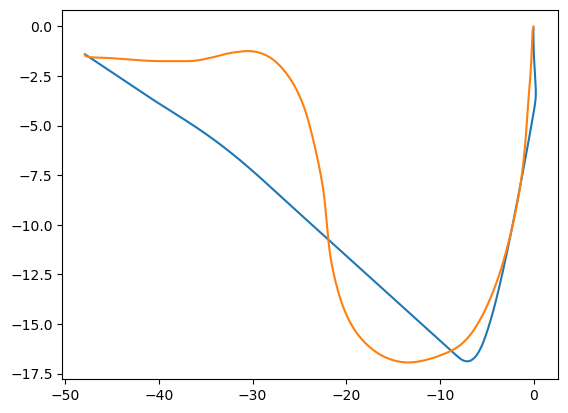

In [28]:
indx = 0
# traj_d_all = traj_spirals_d_all

model_y = model_load_TB(0.93*ts, posn[indx, 0, :])
plt.plot(model_y[:,0], model_y[:,1], label="Model")
# indx = 6
# model_y = model(ts, traj_all_process[indx, 0, :])
# plt.plot(model_y[:,0], model_y[:,1], label="Model")
plt.plot(posn[indx, :, 0], posn[indx, :, 1], label="Real")
# plt.legend()
# plt.tight_layout()

## Libraries and functions for vector field visualization

In [ ]:
def streamQuiver(ax,sp,*args,spacing=None,n=5,**kwargs):
    """ Plot arrows from streamplot data
    The number of arrows per streamline is controlled either by `spacing` or by `n`.
    See `lines_to_arrows`.
    """
    def curve_coord(line=None):
        """ return curvilinear coordinate """
        x=line[:,0]
        y=line[:,1]
        s     = np.zeros(x.shape)
        s[1:] = np.sqrt((x[1:]-x[0:-1])**2+ (y[1:]-y[0:-1])**2)
        s     = np.cumsum(s)
        return s

    def curve_extract(line,spacing,offset=None):
        """ Extract points at equidistant space along a curve"""
        x=line[:,0]
        y=line[:,1]
        if offset is None:
            offset=spacing/2
        # Computing curvilinear length
        s = curve_coord(line)
        offset=np.mod(offset,s[-1]) # making sure we always get one point
        # New (equidistant) curvilinear coordinate
        sExtract=np.arange(offset,s[-1],spacing)
        # Interpolating based on new curvilinear coordinate
        xx=np.interp(sExtract,s,x);
        yy=np.interp(sExtract,s,y);
        return np.array([xx,yy]).T

    def seg_to_lines(seg):
        """ Convert a list of segments to a list of lines """
        def extract_continuous(i):
            x=[]
            y=[]
            # Special case, we have only 1 segment remaining:
            if i==len(seg)-1:
                x.append(seg[i][0,0])
                y.append(seg[i][0,1])
                x.append(seg[i][1,0])
                y.append(seg[i][1,1])
                return i,x,y
            # Looping on continuous segment
            while i<len(seg)-1:
                # Adding our start point
                x.append(seg[i][0,0])
                y.append(seg[i][0,1])
                # Checking whether next segment continues our line
                Continuous= all(seg[i][1,:]==seg[i+1][0,:])
                if not Continuous:
                    # We add our end point then
                    x.append(seg[i][1,0])
                    y.append(seg[i][1,1])
                    break
                elif i==len(seg)-2:
                    # we add the last segment
                    x.append(seg[i+1][0,0])
                    y.append(seg[i+1][0,1])
                    x.append(seg[i+1][1,0])
                    y.append(seg[i+1][1,1])
                i=i+1
            return i,x,y
        lines=[]
        i=0
        while i<len(seg):
            iEnd,x,y=extract_continuous(i)
            lines.append(np.array( [x,y] ).T)
            i=iEnd+1
        return lines

    def lines_to_arrows(lines,n=5,spacing=None,normalize=True):
        """ Extract "streamlines" arrows from a set of lines
        Either: `n` arrows per line
            or an arrow every `spacing` distance
        If `normalize` is true, the arrows have a unit length
        """
        if spacing is None:
            # if n is provided we estimate the spacing based on each curve lenght)
            spacing = [ curve_coord(l)[-1]/n for l in lines]
        try:
            len(spacing)
        except:
            spacing=[spacing]*len(lines)

        lines_s=[curve_extract(l,spacing=sp,offset=sp/2)         for l,sp in zip(lines,spacing)]
        lines_e=[curve_extract(l,spacing=sp,offset=sp/2+0.01*sp) for l,sp in zip(lines,spacing)]
        arrow_x  = [l[i,0] for l in lines_s for i in range(len(l))]
        arrow_y  = [l[i,1] for l in lines_s for i in range(len(l))]
        arrow_dx = [le[i,0]-ls[i,0] for ls,le in zip(lines_s,lines_e) for i in range(len(ls))]
        arrow_dy = [le[i,1]-ls[i,1] for ls,le in zip(lines_s,lines_e) for i in range(len(ls))]

        if normalize:
            dn = [ np.sqrt(ddx**2 + ddy**2) for ddx,ddy in zip(arrow_dx,arrow_dy)]
            arrow_dx = [ddx/ddn for ddx,ddn in zip(arrow_dx,dn)]
            arrow_dy = [ddy/ddn for ddy,ddn in zip(arrow_dy,dn)]
        return  arrow_x,arrow_y,arrow_dx,arrow_dy

    # --- Main body of streamQuiver
    # Extracting lines
    seg   = sp.lines.get_segments() # list of (2, 2) numpy arrays
    lines = seg_to_lines(seg)       # list of (N,2) numpy arrays
    # Convert lines to arrows
    ar_x, ar_y, ar_dx, ar_dy = lines_to_arrows(lines,spacing=spacing,n=n,normalize=True)
    # Plot arrows
    qv=ax.quiver(ar_x, ar_y, ar_dx, ar_dy, *args, angles='xy', **kwargs)
    return qv

# --- Example
# x = np.linspace(-1,1,100)
# y = np.linspace(-1,1,100)
# X,Y=np.meshgrid(x,y)
# u = -np.sin(np.arctan2(Y,X))
# v =  np.cos(np.arctan2(Y,X))

# xseed=np.linspace(0.1,1,4)

# fig=plt.figure()
# ax=fig.add_subplot(111)
# sp = ax.streamplot(x,y,u,v,color='plum',arrowstyle='-',start_points=np.array([xseed,xseed*0]).T,density=30)
# qv = streamQuiver(ax,sp,spacing=0.5, scale=60)
# plt.show()

## **Paper**: motion plan with disturbance illustration using predicted vector field and trajectories

(-0.6, 0.6)

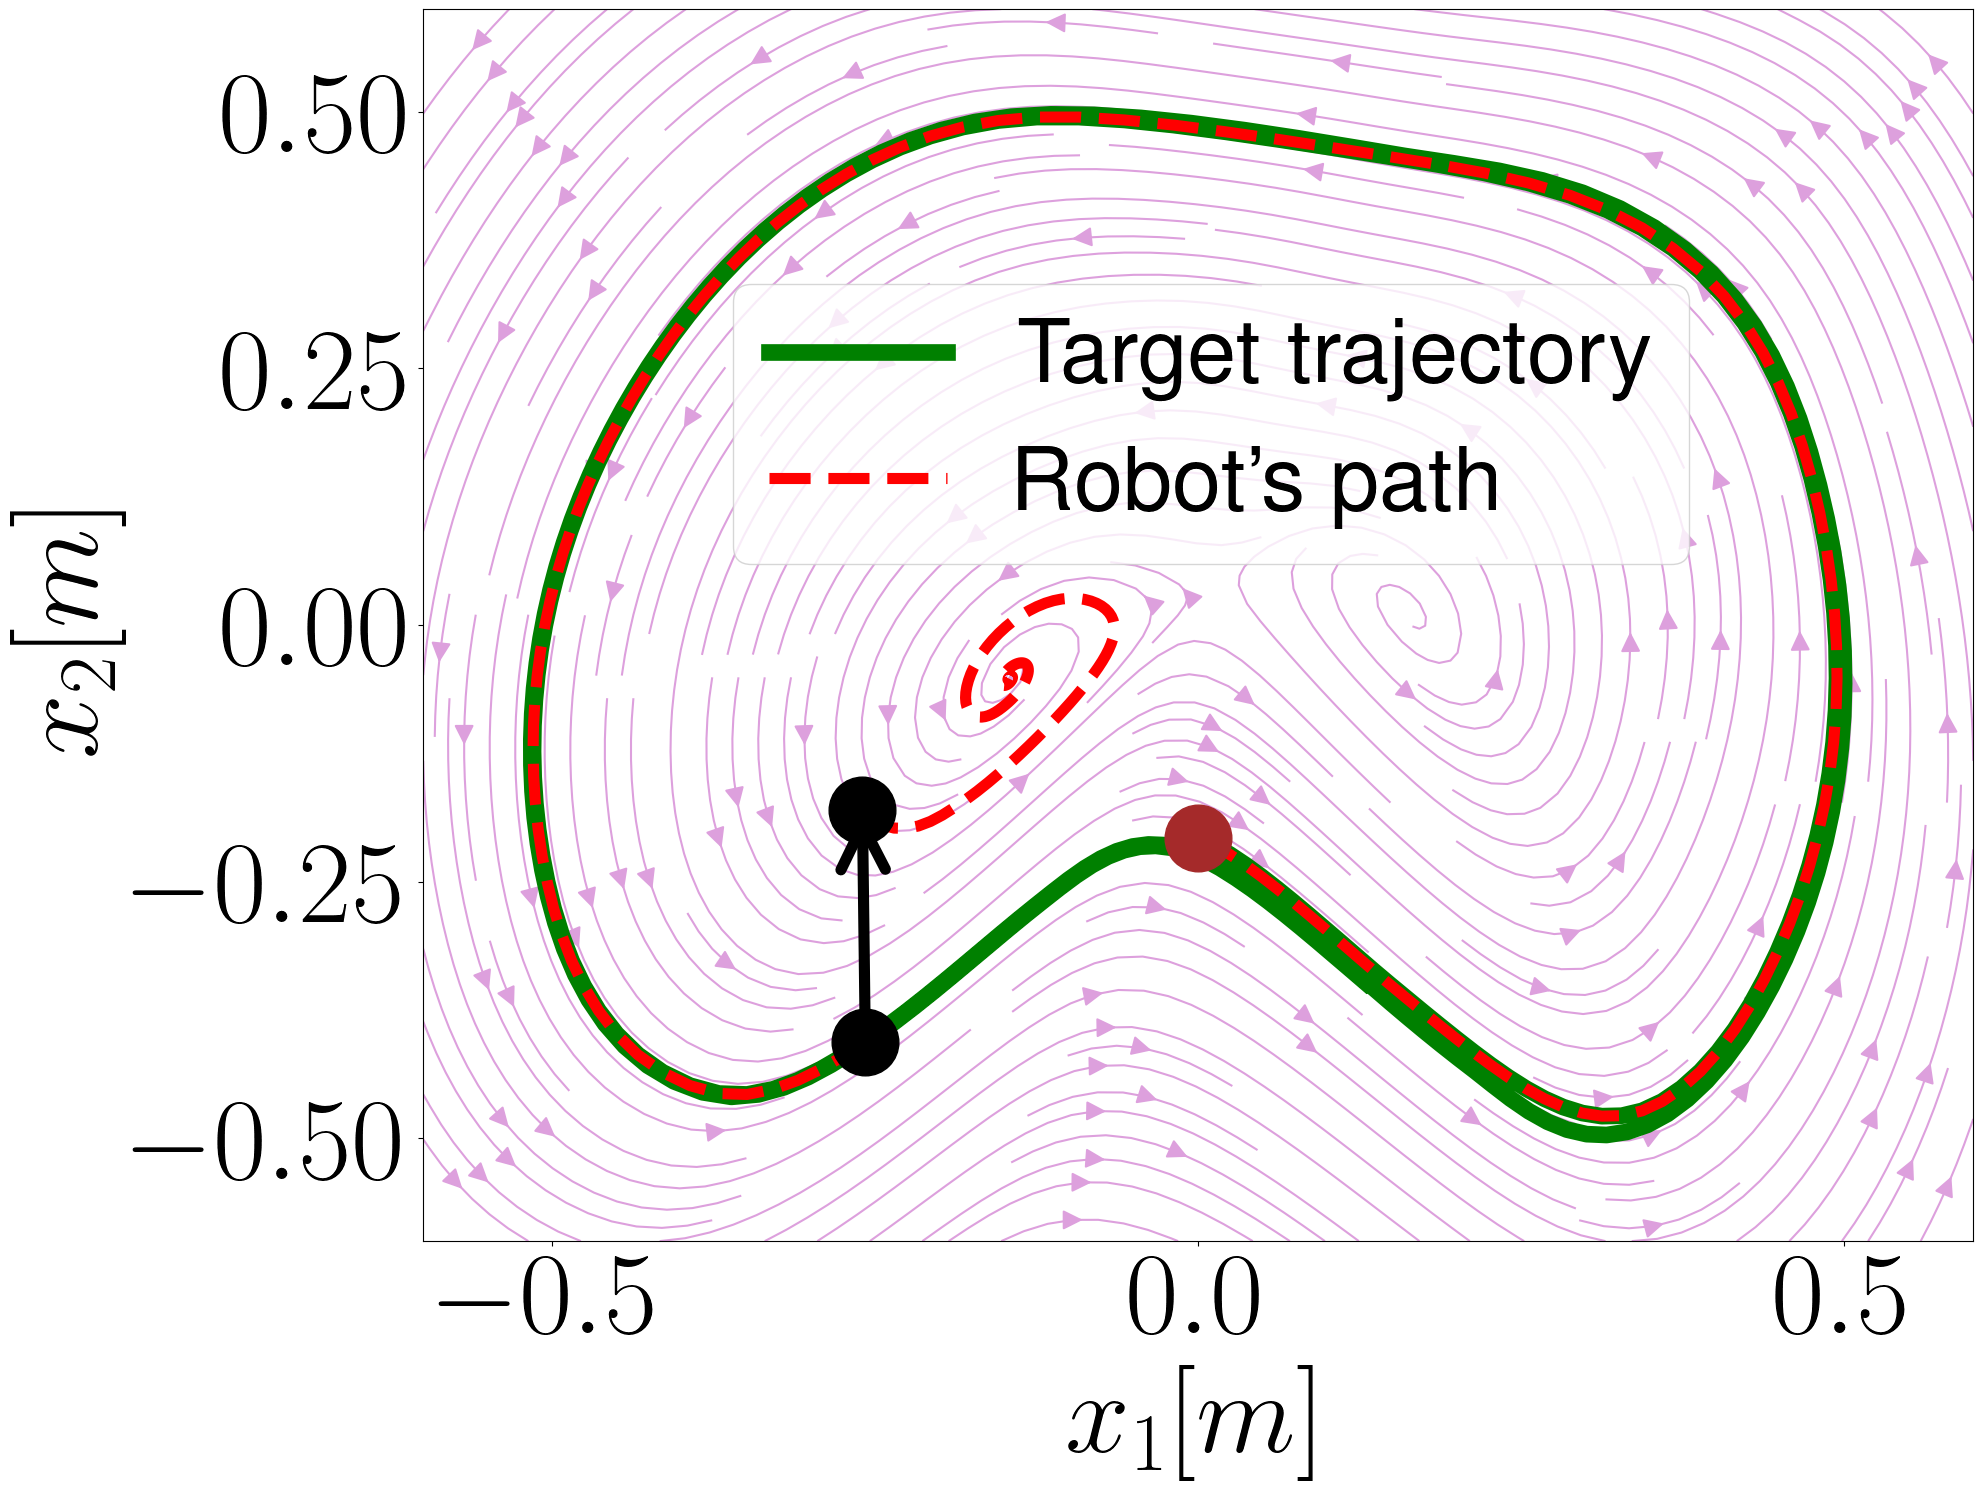

In [ ]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
font = {'size': 84}
matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

xmin = -0.6
xmax = 0.6
ymin = -0.6
ymax = 0.6
(fig, ax) = plt.subplots(nrows=1, ncols=1, figsize=(20,16))
ys = traj_all_process
indx = 0
ts = ts_new
model_load = model_load_TB
f = lambda z : model_load.func(_, z, _)
x, y = np.meshgrid(np.linspace(xmin, xmax, 50),
                   np.linspace(ymin, ymax, 50))
xyz_vec = np.hstack((x.reshape((x.size, -1)), y.reshape((y.size, -1))))
uvw_vec = jax.vmap(f, in_axes=0)(xyz_vec)
proj_uvw = uvw_vec
u = proj_uvw[:, 0].reshape((x.shape[0], x.shape[0]))
v = proj_uvw[:, 1].reshape((y.shape[0], y.shape[0]))
# x, y = np.meshgrid(np.linspace(0.2, 0.8, 50),
#                    np.linspace(-0.6, 0.6, 50))
# plt.quiver(x[:, :, 0], y[:, :, 0], u[:, :, 0], v[:, :, 0], scale = 10, color='g', label='Learnt vector field')
# sp = ax.streamplot(x, y, u ,v, arrowstyle='-', density=3, linewidth=None, color='plum', arrowsize=3)
# streamQuiver(ax, sp, n=5, color='plum', width = 0.01)
sp = ax.streamplot(x, y, u ,v, density=2, color='plum', arrowsize=3)
start = jnp.array([0,-0.207]) # wiping loop 3 spurr_att
# start = traj_all_process[0][0]
model_y = model_load(2*ts, start)
# dist_point = jnp.array([-0.8, -0.3]) # 2nd wiping task converging to goal
# dist_point = jnp.array([-0.65, -0.2]) # 1st wiping task spurr_att
dist_point = jnp.array([-0.26,-0.18]) # wiping loop 3 spurr_att
dist_indx = 125
model_y_dist = model_load(2*ts, dist_point)
g_indx = -1
# ax.annotate('Start', xy=(model_y[0, 0], model_y[0, 1]), xytext=(-50, 25), textcoords='offset points', bbox=dict(boxstyle="round", fc="0.9", alpha=0.6))
# ax.annotate('Goal', xy=(model_y[g_indx, 0], model_y[g_indx, 1]), xytext=(-30, 0), textcoords='offset points', horizontalalignment='right', bbox=dict(boxstyle="round", fc="0.9", alpha=0.6))
# ax.annotate('Disturbance', xy=(model_y[dist_indx, 0], model_y[dist_indx, 1]), xytext=(-25, 5), textcoords='offset points', horizontalalignment='right', bbox=dict(boxstyle="round", fc="0.9", alpha=0.6))
ax.plot(model_y[:, 0], model_y[:, 1], c="green", linewidth='12', label="Target trajectory")
ax.plot(model_y[:dist_indx, 0], model_y[:dist_indx, 1], c="red", linewidth='8', linestyle='--', label="Robot's path")
# ax.plot(xall[:, 0], xall[:, 1], c="red", linewidth='8', linestyle='--')
ax.plot(model_y_dist[:, 0], model_y_dist[:, 1], c="red", linewidth='8', linestyle='--')
ax.plot(start[0], start[1], 'o', color='brown', markersize=48)
# ax.plot(model_y[-1, 0], model_y[-1, 1], marker="o", markersize=48, c="darkblue")
ax.plot(model_y[dist_indx, 0], model_y[dist_indx,1], 'o', color='black', markersize=48)
ax.plot(dist_point[0], dist_point[1], 'o', color='black', markersize=48)
# ax.plot(traj_all_process[0, :, 0], traj_all_process[1,:, 1], c="green", linewidth='5', label="Target trajectory")
## Obstacle
# xc = np.array([-0.27, -0.15])
# r = 0.13
# circle = plt.Circle((xc), r, color='dodgerblue')
# ax.add_artist(circle)
# # ax.plot(xall[:, 0], xall[:, 1], c="red", linewidth='4', linestyle='--')
# ax.plot(model_y[:dist_indx, 0], model_y[:dist_indx, 1], c="red", linewidth='4', linestyle='--', label="Robot's path")
# # ax.plot(model_y[:dist_indx, 0], model_y[:dist_indx, 1], c="red", linewidth='4', linestyle='--', label="Robot's path")
# ax.plot(model_y[0, 0], model_y[0, 1], marker="o", markersize=18, c="saddlebrown")
# # plt.plot(np.array([model_y[130, 0], model_y_dist[0, 0]]), np.array([model_y[130, 1], model_y_dist[0, 1]]), c="green", linewidth='2', label="Disturbance", linestyle='--')
# # plt.arrow(model_y[130, 0], model_y[130, 1], model_y_dist[0, 0] - model_y[130, 0], model_y_dist[0, 1] - model_y[130, 1])
ax.annotate("", xy=(dist_point[0], dist_point[1]), xytext=(model_y[dist_indx, 0], model_y[dist_indx, 1]), arrowprops=dict(mutation_scale=80, arrowstyle="->", linewidth=8)) # Disturbance Arrow
# alpha = 7
# alpha_n = 12
# # ax.annotate("", xy=(alpha_n*(model_y_dist[1, 0]-model_y_dist[0, 0]) + model_y_dist[0, 0], alpha_n*(model_y_dist[1, 1]-model_y_dist[0, 1]) + model_y_dist[0, 1]),
# #             xytext=(model_y_dist[0, 0], model_y_dist[0, 1]), arrowprops=dict(arrowstyle="->", linewidth=4, color='red')) # Arrow
# # ax.annotate("", xy=(alpha*(xall[1, 0] - xall[0, 0]) + xall[0, 0], alpha*(xall[1, 1] - xall[0, 1]) + xall[1, 1]), xytext=(xall[0, 0], xall[0, 1]),
# #             arrowprops=dict(arrowstyle="->", linewidth=4, color='blue')) # Arrow
# ax.plot(model_y[dist_indx, 0], model_y[dist_indx, 1], marker="o", markersize=18, c="black")
# ax.plot(dist_point[0], dist_point[1], marker="o", markersize=18, c="black")
# # plt.plot(traj_all_process[indx, 0, 0], traj_all_process[indx, 0, 1], 'ro')
# # plt.plot(traj_all_process[indx, -1, 0], traj_all_process[indx, -1, 1], 'go')
# # ax.plot(ys[indx, :, 0], ys[indx, :, 1], ys[indx, :, 2], c='red', label='Demonstration')
ax.legend(loc=[0.2, 0.55], fontsize='64')
ax.set_xlabel(r"$x_1 [m]$")
ax.set_ylabel(r"$x_2 [m]$")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
# # ax.set_xlabel('x')
# plt.tight_layout()
# # ax.show()

## Animation of motion with disturbance

In [ ]:
pip install celluloid

/home/zhitao/miniconda3/envs/obs-env/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


Text(0.5, 0, 'x [m]')

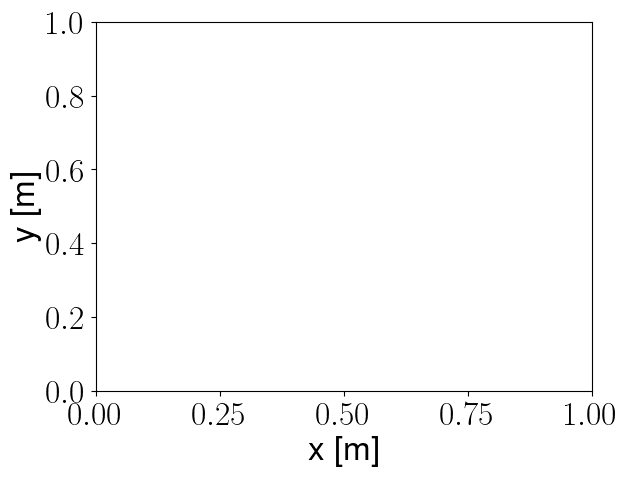

In [ ]:
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera
%matplotlib inline

font = {'size': 24}
matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

(fig, ax) = plt.subplots()

# ax.set(xlim=(-60, 20), ylim=(-15, 25))
ax.set_ylabel('y [m]')
ax.set_xlabel('x [m]')
# ax.get_xaxis().set_label_coords(0.5, 0.12)

# actual_path = jnp.concatenate((model_y[:dist_indx], model_y_dist))

# # Initiate camera
# camera = Camera(fig)

# pause_f = 0

# # Create individual frames
# for j in range(1, actual_path.shape[0]):

#     sp = ax.streamplot(x, y, u ,v, density=1, color='plum', arrowsize=1)

#     ax.plot(model_y[:, 0], model_y[:, 1], c="green", linewidth='2', label="Target trajectory")

#     if j >= 125:
#       if pause_f == 0:
#         pause = 0
#         pause_f = 1
#       ax.annotate("", xy=(model_y_dist[0, 0], model_y_dist[0, 1]), xytext=(model_y[dist_indx, 0], model_y[dist_indx, 1]),
#             arrowprops=dict(arrowstyle="->", linewidth=2)) # Disturbance Arrow
#       ax.plot(model_y[dist_indx, 0], model_y[dist_indx, 1], marker="o", c="black")
#       ax.plot(dist_point[0], dist_point[1], marker="o", c="black")
#       if pause < 5:
#         pause += 1
#         j = 125

#     # Projectile's trajectory
#     x_path = actual_path[0:j, 0]
#     y_path = actual_path[0:j, 1]

#     # Show Projectile's location
#     ax.plot(x_path[-1], y_path[-1], marker='o', markersize=12, markeredgecolor='r', markerfacecolor='r')

#     # Show Projectile's trajectory
#     ax.plot(x_path, y_path, color='red', lw=2, linestyle='--')

#     # Capture frame
#     camera.snap()

# # Create animation
# anim = camera.animate(interval = 300, repeat = True, repeat_delay = 5000)

# Inline display
#HTML(anim.to_html5_video())

In [ ]:
# Create animation
#anim = camera.animate(interval = 50, repeat = True, repeat_delay = 5000)

# Inline display
#HTML(anim.to_html5_video())

# Stability: CLF-QP implementation

In [ ]:
indx = 0
ys = traj_all_process
model_load = model_load_TB
f = lambda z : model_load.func(_, z, _)
xref = model_load(0.93*ts, start)
# x = ys[indx,0,:]
x = dist_point
r = jnp.array([0.05])
xall = jnp.expand_dims(x, axis=0)

N = 5

vopt_all = []

t0i = 0
t1i = ts[1] - ts[0]
dti = t1i

for i in range(dist_indx, int(1*len(ts))-1):

  # if(i==66):
  #   # indx = indx_angle
  #   # model_load = model_load_angle
  #   x = jnp.array([-0.4, -0.25])

  # if(i==600):
  #   indx = indx_spoon
  #   model_load = model_load_spoon
  #   ys = posn_spoon
  #   f = lambda z : model_load.func(_, z, _)

  x_t=np.asarray(x)

  # xref = np.asarray(ys[indx,i,:])

  # closest_ind = np.argmin(np.linalg.norm(xref - x_t, axis=1))

  # go_to_ind = np.clip(closest_ind + N, 0, xref.shape[0])

  # xref_t = xref[go_to_ind]

  xref_t = xref[i]

  tsi = jnp.array([0, dti])
  # tsi_d = jnp.array([ts[i], ts[i+1]])

  alpha_h = 35
  gamma = 0.1
  lambda_v = 0

  Q = np.eye(x_t.shape[0])
  G = 2*((x_t-xref_t).T)
  fx_t = np.asarray(f(x_t))
  fxref_t = np.asarray(f(xref_t))
  # h = -2*(((x_t-xref_t).T)@(fx_t - fxref_t)) + alpha_h*(-(((x_t-xref_t).T)@(x_t-xref_t)) + r**2) # CBF
  h = -2*(((x_t-xref_t).T)@(fx_t - fxref_t)) - alpha_h*((((x_t-xref_t).T)@(x_t-xref_t))) # CLF
  # h = -(alpha_h*(-(((x1-xref_t).T)@(x1-xref_t)) + r**2) + gamma)

  # h = alpha_h*(((x1-xref_t).T)@(x1-xref_t))+gamma

  # h = alpha_h*(-(((x1-xref_t).T)@(x1-xref_t)) + r**2) + gamma

  vopt = cp.Variable(x_t.shape[0])
  prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q)  + lambda_v*cp.pos(G @ vopt - h)),
                  [G @ vopt <= h])

  prob.solve()

  # x = jnp.asarray(x1)

  # f1 = lambda t, z, args : model_load.func(t, z, _) + vopt.value
  # solution = diffrax.diffeqsolve(
  #     diffrax.ODETerm(f1),
  #     diffrax.Tsit5(),
  #     t0=ts[i],
  #     t1=ts[i+1],
  #     dt0=dti,
  #     y0=x,
  #     stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
  #     saveat=diffrax.SaveAt(ts=tsi_d),
  # )

  f1 = lambda z : model_load.func(_, z,_) + vopt.value

  # vopt_all.append(np.linalg.norm(vopt.value))

  xnext = f1(x)*dti + x

  # xnext = solution.ys[-1,:]

  xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)

  x = xnext

  if(i%10==0):
    print(f"Time: {i}, Position: {x}")

Time: 130, Position: [-0.10019661 -0.02505619]
Time: 140, Position: [-0.03313551  0.16902347]
Time: 150, Position: [-0.11622406  0.31677094]
Time: 160, Position: [-0.2274453   0.36322048]
Time: 170, Position: [-0.31575575  0.33519167]
Time: 180, Position: [-0.3835884  0.2721842]
Time: 190, Position: [-0.435773    0.19004984]
Time: 200, Position: [-0.47446576  0.09561097]
Time: 210, Position: [-0.4991559 -0.0083637]
Time: 220, Position: [-0.5084521  -0.12038843]
Time: 230, Position: [-0.50059026 -0.23801298]
Time: 240, Position: [-0.4686294  -0.35551575]
Time: 250, Position: [-0.38981488 -0.44820744]
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Time: 260, Posi

# CBF for obstacle avoidance

In [ ]:
indx = 3
ys = traj_all_process
ts = ts_new
model_load = model_load_TB
f = lambda t, z : model_load.func(t, z, _)
x = ys[indx,0,:]
xall = jnp.expand_dims(ys[indx,0,:], axis=0)
xref = model_load(ts, ys[indx, 0, :])

xc = jnp.array([0, 0.5])
r = jnp.array([0.2])

rho = 0.05

vopt_all = []
cmd_vel = jnp.array([[0, 0]])


for i in range(len(ts)-1):

  dti = ts[i+1] - ts[i]
  xref_t = np.asarray(xref[i, :])

  x_t = np.asarray(x)

  Q = np.eye(x_t.shape[0])
  G_L = 2 * ((x_t - xref_t).T)


  fx_t = np.asarray(f(ts[i], x_t))
  fxref_t = np.asarray(f(ts[i], xref_t))

  alpha_L = 10
  h_L = -2 * ((x_t - xref_t).T @ (fx_t - fxref_t)) - alpha_L * ((x_t - xref_t).T @ (x_t - xref_t))

  # Circular CBF
  B_c = ((x_t - xc).T @ (x_t - xc)) - r**2
  grad_B_c = 2 * (x_t - xc)

  # Solve QP
  vopt = cp.Variable(x_t.shape[0])
  epsilon = cp.Variable((1, 1))
  lambda_v = 20
  alpha_B_c = 100

  prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q) + lambda_v * cp.quad_form(epsilon, np.eye(1))),
      [G_L @ vopt - epsilon <= h_L,
        grad_B_c @ (fx_t + vopt) >= -alpha_B_c * B_c])

  prob.solve()

  # Create modulated dynamics
  f1 = lambda z: model_load.func(0, z, _) + vopt.value

  xnext = f1(x) * dti + x
  xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)
  cmd_vel = jnp.append(cmd_vel, jnp.expand_dims(f1(x), axis=0), axis=0)
  vopt_all.append(np.linalg.norm(vopt.value))

  x = xnext

  if i % 10 == 0:
      print(f"Time: {i}, Position: {x}")

Polishing not needed - no active set detected at optimal point
Time: 0, Position: [-0.49020904 -0.07614897]
Time: 10, Position: [-0.4884296  -0.20086697]
Time: 20, Position: [-0.46179032 -0.32691324]
Time: 30, Position: [-0.38756543 -0.42938343]
Time: 40, Position: [-0.28726897 -0.41986877]
Time: 50, Position: [-0.20683698 -0.35045573]
Time: 60, Position: [-0.13613342 -0.27625257]
Time: 70, Position: [-0.07238597 -0.21773072]
Time: 80, Position: [-0.01216512 -0.20401189]
Time: 90, Position: [ 0.04895921 -0.24553159]
Time: 100, Position: [ 0.11063944 -0.3093561 ]
Time: 110, Position: [ 0.17359608 -0.37771338]
Time: 120, Position: [ 0.23946701 -0.4417746 ]
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Polishing not needed - no active set detected at optimal point
Time: 130, Position: [ 0.31199005 -0.4812822 ]
Polishing not needed - no active set d

0.17942181
Time: 0, Position: [-0.49020946 -0.07615534]
0.16722901
0.15497851
0.14267324
0.13031738
0.11791668
0.10547963
0.09301881
0.080553964
0.06811852
0.05577421
Time: 10, Position: [-0.48841888 -0.20094542]
0.043650247
0.032065347
0.02198578
0.016575834
0.020148028
0.029669419
0.041240867
0.05357469
0.06626307
0.07914485
Time: 20, Position: [-0.4617171 -0.3270674]
0.09214054
0.105200805
0.11828686
0.13136087
0.14438172
0.15730129
0.1700612
0.18258771
0.19478472
0.20652469
Time: 30, Position: [-0.38728374 -0.42948228]
0.2176414
0.22793254
0.23718444
0.24522503
0.2519927
0.25760892
0.2623076
0.2663445
0.26993567
0.27324635
Time: 40, Position: [-0.28698263 -0.41961598]
0.27639982
0.2794887
0.28258348
0.28573847
0.28899568
0.2923875
0.29593852
0.2996669
0.3035852
0.30770156
Time: 50, Position: [-0.20658664 -0.35010535]
0.31201988
0.31654078
0.32126182
0.3261781
0.33128235
0.33656555
0.34201714
0.34762502
0.35337624
0.35925686
Time: 60, Position: [-0.1359101 -0.2758799]
0.36525238
0.3

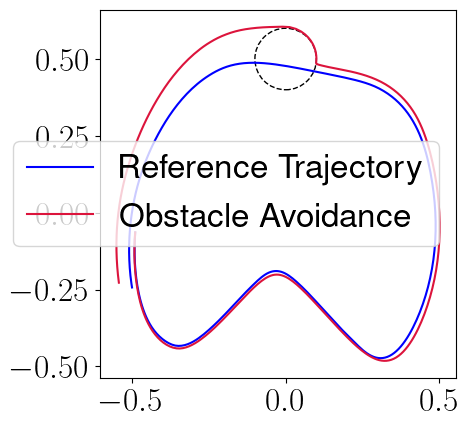

In [ ]:
indx = 3
ys = traj_all_process
ts = ts_new
model_load = model_load_TB
f = lambda t, z: model_load.func(t, z, _)

# Initial state
x = ys[indx, 0, :]
xall = jnp.expand_dims(x, axis=0)
xref = model_load(ts, ys[indx, 0, :])  # Reference trajectory

# Obstacle parameters
xc = jnp.array([0, 0.5])  # Obstacle center
r = jnp.array([0.1])      # Radius

# Storage
vopt_all = []
cmd_vel = jnp.array([[0, 0]])

# CLF-CBF parameters
# alpha_L = 4
# alpha_B_c = 4
# lambda_v = 0.1

# lambda_v = 5
# alpha_B_c = 25
# alpha_L = 30

lambda_v = 10
alpha_B_c = 100
alpha_L = 50
Q = np.eye(x.shape[0])
tol = 0.05
max_iters = 400
target = np.asarray(xref[-1])

for i in range(max_iters):
    # Break if reached target
    print(np.linalg.norm(x - target))
    if np.linalg.norm(x - target) < tol and i >= ts.shape[0]:
        print(f"Reached target at step {i}")
        break

    # Closest point on trajectory
    dists = np.linalg.norm(xref - np.asarray(x), axis=1)
    i_closest = np.argmin(dists)

    # Next reference point
    if i_closest < len(xref) - 1:
        xref_t = np.asarray(xref[i_closest + 1])
        dti = ts[i_closest + 1] - ts[i_closest]
    else:
        xref_t = np.asarray(xref[-1])
        dti = 0.05  # small step size if at end

    x_t = np.asarray(x)
    G_L = 2 * ((x_t - xref_t).T)

    fx_t = np.asarray(f(0, x_t))
    fxref_t = np.asarray(f(0, xref_t))

    h_L = -2 * ((x_t - xref_t).T @ (fx_t - fxref_t)) - alpha_L * ((x_t - xref_t).T @ (x_t - xref_t))

    # CBF constraint
    B_c = ((x_t - xc).T @ (x_t - xc)) - r**2
    grad_B_c = 2 * (x_t - xc)

    # QP
    vopt = cp.Variable(x_t.shape[0])
    epsilon = cp.Variable((1, 1))

    prob = cp.Problem(cp.Minimize(cp.quad_form(vopt, Q) + lambda_v * cp.quad_form(epsilon, np.eye(1))),
                      [G_L @ vopt - epsilon <= h_L,
                       grad_B_c @ (fx_t + vopt) >= -alpha_B_c * B_c])

    prob.solve()

    if prob.status != cp.OPTIMAL:
        print(f"QP failed at step {i}, status: {prob.status}")
        break

    # Apply modulated dynamics
    f1 = lambda z: model_load.func(0, z, _) + vopt.value
    xnext = f1(x) * dti + x

    # Store
    xall = jnp.append(xall, jnp.expand_dims(xnext, axis=0), axis=0)
    cmd_vel = jnp.append(cmd_vel, jnp.expand_dims(f1(x), axis=0), axis=0)
    vopt_all.append(np.linalg.norm(vopt.value))

    x = xnext

    if i % 10 == 0:
        print(f"Time: {i}, Position: {x}")

# ========================
# Plotting
# ========================
fig, ax = plt.subplots()

# Plot reference trajectory
model_y = model_load(ts, traj_all_process[indx, 0])
plt.plot(model_y[:, 0], model_y[:, 1], c="blue", label="Reference Trajectory")

# Plot obstacle-avoidance trajectory
plt.plot(xall[:, 0], xall[:, 1], c="crimson", label="Obstacle Avoidance")

# Plot obstacle
circle = plt.Circle((xc[0].item(), xc[1].item()), r.item(), fill=False, edgecolor='black', linestyle='--')
ax.add_artist(circle)

ax.set_aspect('equal')
plt.legend()
plt.tight_layout()
plt.show()

[0.5 0. ]


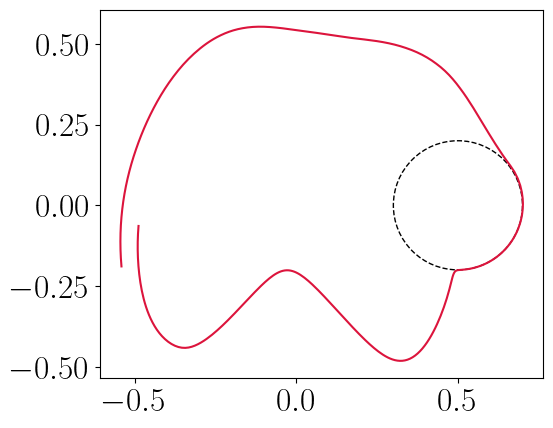

In [ ]:
figure, axes = plt.subplots()

# Plot obstacle-avoidance trajectory
plt.plot(xall[:, 0], xall[:, 1], c="crimson", label="Obstacle avoidance")

# Plot model trajectory
model_y = model_load(ts, traj_all_process[indx, 0])

# Add obstacle
circle = plt.Circle((xc[0].item(), xc[1].item()), r.item(), fill=False, edgecolor='black', linestyle='--')
print(xc)
axes.set_aspect('equal')
axes.add_artist(circle)

plt.tight_layout()
#plt.legend()
plt.show()
